In [51]:
import numpy as np
import random
import matplotlib.pyplot as plt


cards = [('2',2),('3',3),('4',4),('5',5),('6',6),('7',7),('8',8),('9',9),('10',10),
         ('J',10),('Q',10),('K',10),
         ('A',1)]

def card_value(card):
    return card[1]

def card_is_ace(card):
    return card[0] == 'A'


states = []

for dealer_card in cards:
    for curr_sum in range(12, 22):
        for usable_ace in ([True, False] if curr_sum <= 12 else [False]):
            states.append((curr_sum, dealer_card, usable_ace))


def s_curr_sum(s):
    return s[0]

def s_dealer_card(s):
    return s[1]

def s_usable_ace(s):
    return s[2]

def is_terminal(state):
    if s_usable_ace(state) and s_curr_sum(state) == 11:
        return True
    return s_curr_sum(state) >= 21

HIT = 0
STICK = 1
    
def actions(state):
    if s_curr_sum(state) < 21:
        return [HIT, STICK]
    return [STICK]


def generate_episode(pi, s):
    episode = []

    while not is_terminal(s):
        sp = random.uniform(0, 1)
        if sp <= pi[(s, STICK)]:
            episode.append((s, STICK))
            break

        episode.append((s, HIT))
        nc = random.choice(cards)

        new_sum = s_curr_sum(s) + card_value(nc)
        if_usable_ace = new_sum <= 11 and (card_is_ace(nc) or s_usable_ace(s))
        s = (new_sum, s_dealer_card(s), if_usable_ace)

    if s_curr_sum(s) == 21:
        episode.append((s, STICK))


    nc = random.choice(cards)
    ds = card_value(s_dealer_card(s)) + card_value(nc)
    dealer_ace_sum = ds + 10

    dealer_win = (card_is_ace(nc) or card_is_ace(s_dealer_card(s))) \
                           and s_curr_sum(s) <= dealer_ace_sum <= 21
    
    if dealer_win or s_curr_sum(s) <= ds <= 21 or s_curr_sum(s) >= 21:
        return episode, -1
    
    return episode, +1


def on_policy_first_visit_mc_control(eps, iter_num):
    Q = {}
    R = {}
    pi = {}
    for s in states:
        for a in actions(s):
            Q[(s, a)] = 0
            R[(s, a)] = []
            pi[(s, a)] = 1 / len(actions(s))

    n = 0
    while n < iter_num:
        ss = random.choice(states)
        episode, r = generate_episode(pi, ss)

        for s, a in episode:
            R[(s, a)].append(r)
            Q[(s, a)] = np.mean(R[(s, a)])

        episode_states = list(set([s for s, _ in episode]))
        
        for s in episode_states:
            i = np.argmax([Q[(s, a)] for a in actions(s)])
            max_a = actions(s)[i]
            
            for a in actions(s):
                if a == max_a:
                    pi[(s, a)] = 1 - eps + eps / len(actions(s))
                else:
                    pi[(s, a)] = eps / len(actions(s))

        n += 1
    return pi


def win_rate(pi, n=1000):
    win_cnt = 0
    for _ in range(n):
        episode, r = generate_episode(pi, random.choice(states))
        if r == 1:
            win_cnt += 1
    return win_cnt / n

In [52]:
random.seed(666)

win_rates = [rate for n in range(1,10000,100)
             for pi in [on_policy_first_visit_mc_control(0.4, n)]
             for rate in [win_rate(pi)]]

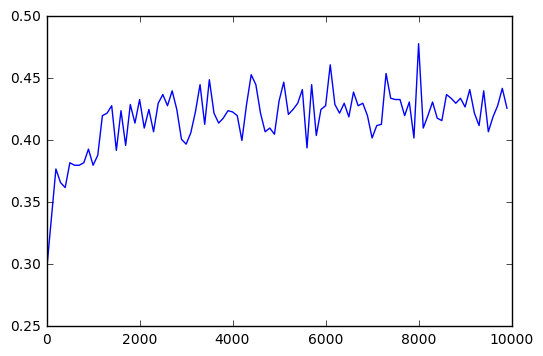

In [53]:
%matplotlib inline
plt.plot(range(1,10000,100), win_rates)